In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras_cv")
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

import json
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_cv
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

JSON_DIR = '/workspace/DeepPCB_split/train/' # train Ìè¥Îçî ÏïàÏóêÎäî 1000Ïû•Ïùò Ïù¥ÎØ∏ÏßÄÏôÄ 1000Ïû•Ïùò ÎùºÎ≤®Ïù¥ Í∑∏Î†§ÏßÑ json ÌååÏùºÏù¥ ÏûàÏùå
IMAGE_DIR = '/workspace/DeepPCB_split/train/'
IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 500

In [ ]:
# json ÌååÏùº ÌååÏã±ÌïòÏó¨ DataFrame ÎßåÎì§Í∏∞
print("1Îã®Í≥Ñ: JSON ÌååÏùº ÌååÏã± ÏãúÏûë")
class_mapping = {
    'open': 0, 'short': 1, 'mousebite': 2, 'spur': 3, 'copper': 4, 'pin-hole': 5
}
data_rows = []
json_files = [f for f in os.listdir(JSON_DIR) if f.endswith('.json')]
for filename in json_files:
    json_path = os.path.join(JSON_DIR, filename)
    with open(json_path, 'r') as f:
        labelme_data = json.load(f)
        json_base_dir = os.path.dirname(json_path)
        image_path = os.path.normpath(os.path.join(json_base_dir, labelme_data['imagePath']))
        
    boxes, class_ids = [], []
    for shape in labelme_data['shapes']:
        label = shape['label']
        if label not in class_mapping: continue
        class_id = class_mapping[label]
        points = shape['points']
        x_min, y_min = min(points[0][0], points[1][0]), min(points[0][1], points[1][1])
        x_max, y_max = max(points[0][0], points[1][0]), max(points[0][1], points[1][1])
        boxes.append([x_min, y_min, x_max, y_max])
        class_ids.append(class_id)
    if boxes:
        data_rows.append({"image_path": image_path, "boxes": boxes, "class_ids": class_ids})

full_dataset_df = pd.DataFrame(data_rows)
train_df, val_df = train_test_split(full_dataset_df, test_size=0.2, random_state=42)
print(f"‚úÖ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Î∞è Î∂ÑÌï† ÏôÑÎ£å! (ÌïôÏäµ: {len(train_df)}, Í≤ÄÏ¶ù: {len(val_df)})")

--- 1Îã®Í≥Ñ: JSON ÌååÏùº ÌååÏã± ÏãúÏûë ---
‚úÖ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Î∞è Î∂ÑÌï† ÏôÑÎ£å! (ÌïôÏäµ: 800, Í≤ÄÏ¶ù: 200)


In [75]:
# --- 2Îã®Í≥Ñ: `tf.data` ÌååÏù¥ÌîÑÎùºÏù∏ Ïû¨Íµ¨Ï∂ï (Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ìè¨Ìï®) ---
print("\n--- 2Îã®Í≥Ñ: tf.data ÌååÏù¥ÌîÑÎùºÏù∏ Ïû¨Íµ¨Ï∂ï ÏãúÏûë (Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ìè¨Ìï®) ---")

def _build_base_dataset(dataframe): 
    
    dataset = tf.data.Dataset.from_generator(
        lambda: dataframe.to_dict(orient='records'),
        output_signature={
            'image_path': tf.TensorSpec(shape=(), dtype=tf.string),
            'boxes': tf.TensorSpec(shape=(None, 4), dtype=tf.float32), 
            'class_ids': tf.TensorSpec(shape=(None,), dtype=tf.int32) 
        }
    )
    
    def load_and_resize(data):
        image_path = data["image_path"]
        
        raw_image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(raw_image, channels=3)
        
        original_height = tf.cast(tf.shape(image)[0], tf.float32)
        original_width = tf.cast(tf.shape(image)[1], tf.float32)

        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = tf.cast(image, dtype=tf.float32) / 255.0

        boxes = data["boxes"] 
        scale_x = tf.cast(IMG_SIZE, tf.float32) / original_width
        scale_y = tf.cast(IMG_SIZE, tf.float32) / original_height

        scaled_boxes = tf.stack([
            boxes[:, 0] * scale_x,
            boxes[:, 1] * scale_y,
            boxes[:, 2] * scale_x,
            boxes[:, 3] * scale_y
        ], axis=-1)

        bounding_boxes = {
            "boxes": scaled_boxes,
            "classes": tf.cast(data["class_ids"], dtype=tf.float32) 
        }
        return {"images": image, "bounding_boxes": bounding_boxes}

    dataset = dataset.map(load_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.apply(tf.data.experimental.ignore_errors()) 
    
    dataset = dataset.filter(
        lambda x: tf.greater(tf.shape(x["bounding_boxes"]["boxes"])[0], 0)
    )
    
    return dataset 

base_train_ds = _build_base_dataset(train_df)
base_val_ds = _build_base_dataset(val_df)

print("\n--- ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå Ïàò Í≥ÑÏÇ∞ Ï§ë (ÏãúÍ∞ÑÏù¥ Îã§ÏÜå ÏÜåÏöîÎê† Ïàò ÏûàÏäµÎãàÎã§) ---")

actual_train_samples_after_filter = 0
for _ in base_train_ds:
    actual_train_samples_after_filter += 1
print(f"ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïã§Ï†ú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå Ïàò: {actual_train_samples_after_filter}")

actual_val_samples_after_filter = 0
for _ in base_val_ds:
    actual_val_samples_after_filter += 1
print(f"ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïã§Ï†ú Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå Ïàò: {actual_val_samples_after_filter}")

STEPS_PER_EPOCH_TRAIN = actual_train_samples_after_filter // BATCH_SIZE
STEPS_PER_EPOCH_VAL = actual_val_samples_after_filter // BATCH_SIZE

if STEPS_PER_EPOCH_TRAIN == 0: STEPS_PER_EPOCH_TRAIN = 1
if STEPS_PER_EPOCH_VAL == 0: STEPS_PER_EPOCH_VAL = 1

print(f"DEBUG: ÏµúÏ¢Ö Í≥ÑÏÇ∞Îêú STEPS_PER_EPOCH_TRAIN: {STEPS_PER_EPOCH_TRAIN}") 
print(f"DEBUG: ÏµúÏ¢Ö Í≥ÑÏÇ∞Îêú STEPS_PER_EPOCH_VAL: {STEPS_PER_EPOCH_VAL}")   

print("ÏµúÏ¢Ö ÎîîÎ≤ÑÍπÖÏö© Îç∞Ïù¥ÌÑ∞ ÌååÏù¥ÌîÑÎùºÏù∏ Íµ¨Ï∂ï ÏôÑÎ£å.")

def _build_final_dataset_for_fit(base_dataset, batch_size, is_training): 
    dataset = base_dataset
    if is_training:
        augmenter = keras.Sequential(
            [
                keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
                keras_cv.layers.RandomRotation(factor=(-0.05, 0.05), bounding_box_format="xyxy"),
                keras_cv.layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), bounding_box_format="xyxy"), # Ïù¥Ï†Ñ Î≤îÏúÑÎ°ú Ï∂ïÏÜå
                
                keras_cv.layers.RandomBrightness(value_range=(0.0, 1.0), factor=(0.0, 1.0)), 
                keras_cv.layers.RandomContrast(value_range=(0.0, 1.0), factor=(0.15, 0.75)), 
                keras_cv.layers.RandomSaturation(factor=(0.4, 1.0)), 
                keras_cv.layers.RandomHue(value_range=(0.0, 1.0), factor=(0.05, 0.15)),      
                
                keras_cv.layers.JitteredResize( 
                    target_size=(IMG_SIZE, IMG_SIZE), 
                    scale_factor=(0.8, 1.2),
                    bounding_box_format="xyxy",
                )
            ],
            name="data_augmentation",
        )
        dataset = dataset.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
        
        dataset = dataset.repeat() 

    dataset = dataset.padded_batch(
        batch_size=batch_size,
        padding_values={
            "images": tf.constant(0.0, dtype=tf.float32),
            "bounding_boxes": {
                "boxes": tf.constant(-1.0, dtype=tf.float32),
                "classes": tf.constant(-1.0, dtype=tf.float32) 
            }
        },
        padded_shapes={
            "images": [IMG_SIZE, IMG_SIZE, 3],
            "bounding_boxes": {
                "boxes": [None, 4],
                "classes": [None]
            }
        },
        drop_remainder=True
    )
    
    def dict_to_tuple(inputs):
        return inputs["images"], inputs["bounding_boxes"]
    
    dataset = dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset.prefetch(tf.data.AUTOTUNE)

# Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
train_ds = _build_final_dataset_for_fit(base_train_ds, BATCH_SIZE, is_training=True)
val_ds = _build_final_dataset_for_fit(base_val_ds, BATCH_SIZE, is_training=False)


--- 2Îã®Í≥Ñ: tf.data ÌååÏù¥ÌîÑÎùºÏù∏ Ïû¨Íµ¨Ï∂ï ÏãúÏûë (Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ìè¨Ìï®) ---

--- ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå Ïàò Í≥ÑÏÇ∞ Ï§ë (ÏãúÍ∞ÑÏù¥ Îã§ÏÜå ÏÜåÏöîÎê† Ïàò ÏûàÏäµÎãàÎã§) ---
ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïã§Ï†ú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå Ïàò: 303
ÌïÑÌÑ∞ÎßÅ ÌõÑ Ïã§Ï†ú Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå Ïàò: 70
DEBUG: ÏµúÏ¢Ö Í≥ÑÏÇ∞Îêú STEPS_PER_EPOCH_TRAIN: 75
DEBUG: ÏµúÏ¢Ö Í≥ÑÏÇ∞Îêú STEPS_PER_EPOCH_VAL: 17
ÏµúÏ¢Ö ÎîîÎ≤ÑÍπÖÏö© Îç∞Ïù¥ÌÑ∞ ÌååÏù¥ÌîÑÎùºÏù∏ Íµ¨Ï∂ï ÏôÑÎ£å.


In [76]:
# --- 4Îã®Í≥Ñ: KerasCV Î™®Îç∏ ÏÉùÏÑ± Î∞è Ïª¥ÌååÏùº ---
print("\n--- 4Îã®Í≥Ñ: KerasCV Î™®Îç∏ ÏÉùÏÑ± Î∞è Ïª¥ÌååÏùº ---")
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco", load_weights=True)
model = keras_cv.models.YOLOV8Detector(
    backbone=backbone,
    num_classes=len(class_mapping),
    bounding_box_format="xyxy"
)
initial_learning_rate = 2e-5 
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=EPOCHS * STEPS_PER_EPOCH_TRAIN, 
    warmup_steps=int(0.2 * EPOCHS * STEPS_PER_EPOCH_TRAIN) 
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, global_clipnorm=10.0), 
    classification_loss="binary_crossentropy",
    box_loss="ciou"
)
print("‚úÖ Î™®Îç∏ ÏÉùÏÑ± Î∞è Ïª¥ÌååÏùº ÏôÑÎ£å.")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

# --- 5Îã®Í≥Ñ: Î™®Îç∏ ÌïôÏäµ ---
print("\n--- 5Îã®Í≥Ñ: Î™®Îç∏ ÌïôÏäµ ÏãúÏûë ---")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras", monitor="val_box_loss", save_best_only=True, mode="min"
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_box_loss',       
    patience=40,            
    restore_best_weights=True,
    mode='min' 
)
history = model.fit(
    train_ds, 
    steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
    validation_data=val_ds,
    validation_steps=STEPS_PER_EPOCH_VAL,
    epochs=EPOCHS, 
    callbacks=[checkpoint_callback, tensorboard_callback, early_stopping_callback]
)
print("\nüéâ Î™®Îç∏ ÌïôÏäµÏù¥ Î™®Îëê ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")


--- 4Îã®Í≥Ñ: KerasCV Î™®Îç∏ ÏÉùÏÑ± Î∞è Ïª¥ÌååÏùº ---
‚úÖ Î™®Îç∏ ÏÉùÏÑ± Î∞è Ïª¥ÌååÏùº ÏôÑÎ£å.

--- 5Îã®Í≥Ñ: Î™®Îç∏ ÌïôÏäµ ÏãúÏûë ---
Epoch 1/500
75/75 [==============================] - 36s 148ms/step - loss: 1331.2526 - box_loss: 6.0196 - class_loss: 1325.2330 - val_loss: 1473.1759 - val_box_loss: 5.3391 - val_class_loss: 1467.8368
Epoch 2/500
75/75 [==============================] - 6s 83ms/step - loss: 1099.2552 - box_loss: 6.1231 - class_loss: 1093.1320 - val_loss: 1427.5432 - val_box_loss: 5.5154 - val_class_loss: 1422.0280
Epoch 3/500
75/75 [==============================] - 6s 84ms/step - loss: 915.7932 - box_loss: 6.0421 - class_loss: 909.7510 - val_loss: 943.7417 - val_box_loss: 5.6879 - val_class_loss: 938.0538
Epoch 4/500
75/75 [==============================] - 6s 83ms/step - loss: 744.4165 - box_loss: 6.2612 - class_loss: 738.1554 - val_loss: 829.5272 - val_box_loss: 6.0023 - val_class_loss: 823.5249
Epoch 5/500
75/75 [==============================] - 6s 75ms/step - loss:

In [77]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## 6Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä Î∞è mAP Í≥ÑÏÇ∞

print("\n--- 6Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä Î∞è mAP Í≥ÑÏÇ∞ ÏãúÏûë ---")

# pycocotools ÏßÅÏ†ë ÏûÑÌè¨Ìä∏
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

model_to_evaluate = model 

predict_ds_for_inference = val_ds.map(lambda images, bounding_boxes: images, num_parallel_calls=tf.data.AUTOTUNE)
predict_results_batched_tensors = model_to_evaluate.predict(predict_ds_for_inference, steps=STEPS_PER_EPOCH_VAL)

ground_truths_coco_format = [] 
predictions_coco_format = []   
image_id_counter = 0           
annotation_id_counter = 0      

coco_images = [] 
coco_categories = [{"id": int(v), "name": k} for k, v in class_mapping.items()]

confidence_threshold = 0.05


for images_batch, bounding_boxes_batch in val_ds.take(STEPS_PER_EPOCH_VAL):
    for i in range(images_batch.shape[0]): 
        current_image_id = image_id_counter
        image_id_counter += 1

        coco_images.append({
            "id": current_image_id,
            "width": IMG_SIZE, 
            "height": IMG_SIZE,
            "file_name": f"image_{current_image_id}.jpg" 
        })

        gt_boxes = bounding_boxes_batch["boxes"][i].numpy() 
        gt_classes = bounding_boxes_batch["classes"][i].numpy()

        valid_indices = gt_classes != -1 
        gt_boxes_filtered = gt_boxes[valid_indices] 
        gt_classes_filtered = gt_classes[valid_indices] 
        
        gt_boxes_xywh = np.copy(gt_boxes_filtered) 
        if len(gt_boxes_xywh) > 0: 
            gt_boxes_xywh[:, 2] = gt_boxes_xywh[:, 2] - gt_boxes_xywh[:, 0] 
            gt_boxes_xywh[:, 3] = gt_boxes_xywh[:, 3] - gt_boxes_xywh[:, 1] 

        for box_idx in range(len(gt_boxes_filtered)): 
            ground_truths_coco_format.append({
                "id": annotation_id_counter,
                "image_id": current_image_id,
                "category_id": int(gt_classes_filtered[box_idx]), 
                "bbox": gt_boxes_xywh[box_idx].tolist(), 
                "area": float(gt_boxes_xywh[box_idx][2] * gt_boxes_xywh[box_idx][3]),
                "iscrowd": 0 
            })
            annotation_id_counter += 1

        current_pred_boxes = predict_results_batched_tensors["boxes"][current_image_id]
        current_pred_classes = predict_results_batched_tensors["classes"][current_image_id]
        current_pred_confidence = predict_results_batched_tensors["confidence"][current_image_id]
        
        mask_pred = current_pred_confidence >= confidence_threshold
        
        filtered_pred_boxes = current_pred_boxes[mask_pred]
        filtered_pred_classes = current_pred_classes[mask_pred]
        filtered_pred_confidence = current_pred_confidence[mask_pred]

        filtered_pred_boxes_xywh = np.copy(filtered_pred_boxes)
        if len(filtered_pred_boxes_xywh) > 0:
            filtered_pred_boxes_xywh[:, 2] = filtered_pred_boxes_xywh[:, 2] - filtered_pred_boxes_xywh[:, 0]
            filtered_pred_boxes_xywh[:, 3] = filtered_pred_boxes_xywh[:, 3] - filtered_pred_boxes_xywh[:, 1]
        
        for box_idx in range(len(filtered_pred_boxes)): 
            predictions_coco_format.append({
                "image_id": current_image_id, 
                "category_id": int(filtered_pred_classes[box_idx]),
                "bbox": filtered_pred_boxes_xywh[box_idx].tolist(),
                "score": float(filtered_pred_confidence[box_idx]) 
            })


# --- COCO Metric Í≥ÑÏÇ∞ using pycocotools ---
# 1. COCO ground truth Í∞ùÏ≤¥ ÏÉùÏÑ±
coco_gt = COCO()
coco_gt.dataset = {
    "info": {},
    "images": coco_images,
    "annotations": ground_truths_coco_format,
    "categories": coco_categories
}
coco_gt.createIndex()

# [ÌïµÏã¨ ÏàòÏ†ï] ÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä ÏóÜÏùÑ Í≤ΩÏö∞, ÌèâÍ∞ÄÎ•º Ïã§ÌñâÌïòÏßÄ ÏïäÍ≥† Í≤∞Í≥ºÎ•º 0ÏúºÎ°ú Ï≤òÎ¶¨
if not predictions_coco_format:
    print("WARNING: ÏòàÏ∏°Îêú Í∞ùÏ≤¥Í∞Ä ÏóÜÏñ¥ mAPÎäî 0ÏûÖÎãàÎã§.")
    # mAP Í≤∞Í≥ºÎ•º Î™®Îëê 0ÏúºÎ°ú ÏßÅÏ†ë ÏÑ§Ï†ïÌï©ÎãàÎã§.
    mAP_results = {
        'AP': 0.0,
        'AP50': 0.0,
        'AP75': 0.0
    }
else:
    # ÏòàÏ∏° Í≤∞Í≥ºÍ∞Ä ÏûàÏùÑ ÎïåÎßå Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÌèâÍ∞ÄÎ•º ÏßÑÌñâÌï©ÎãàÎã§.
    coco_dt = coco_gt.loadRes(predictions_coco_format)

    # 3. COCOeval Í∞ùÏ≤¥ ÏÉùÏÑ± Î∞è ÌèâÍ∞Ä
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # ÏµúÏ¢Ö mAP Í≤∞Í≥º Ï∂îÏ∂ú
    mAP_results = {
        'AP': coco_eval.stats[0],
        'AP50': coco_eval.stats[1],
        'AP75': coco_eval.stats[2]
    }

# --- mAP ÌèâÍ∞Ä Í≤∞Í≥º ---
# Ïù¥Ï†ú 'metrics/' Ï†ëÎëêÏÇ¨Î•º Î∂ôÏó¨ÏÑú Ï∂úÎ†•Ìï©ÎãàÎã§.
print("--- mAP ÌèâÍ∞Ä Í≤∞Í≥º ---")
for metric_name, value in mAP_results.items():
    # AP, AP50, AP75 ÌÇ§Ïóê ÎåÄÌï¥ÏÑúÎßå 'metrics/'Î•º Î∂ôÏó¨Ï§çÎãàÎã§.
    print(f"metrics/{metric_name}: {value:.4f}")

print("\nüéâ Î™®Îç∏ ÌèâÍ∞Ä ÏôÑÎ£å!")


--- 6Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä Î∞è mAP Í≥ÑÏÇ∞ ÏãúÏûë ---
17/17 [==============================] - 2s 27ms/step
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.175
 Avera

In [78]:
import numpy as np
from tqdm import tqdm # ÏßÑÌñâ ÏÉÅÌô©ÏùÑ Î≥¥Ïó¨Ï£ºÍ∏∞ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨

# 1. ÏòàÏ∏° Í≤∞Í≥ºÎäî Ìïú Î≤àÎßå Î∞õÏïÑÏòµÎãàÎã§.
print("Î™®Îç∏ ÏòàÏ∏°ÏùÑ Ìïú Î≤àÎßå ÏàòÌñâÌï©ÎãàÎã§...")
predict_ds_for_inference = val_ds.map(lambda images, bounding_boxes: images)
all_predictions = model.predict(predict_ds_for_inference, steps=STEPS_PER_EPOCH_VAL)
print("‚úÖ ÏòàÏ∏° ÏôÑÎ£å.")

# 2. ÌÖåÏä§Ìä∏Ìï† ÏûÑÍ≥ÑÍ∞íÎì§ÏùÑ Ï†ïÏùòÌï©ÎãàÎã§.
confidence_thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
iou_thresholds = [0.3, 0.4, 0.45, 0.5, 0.6]

best_map50 = -1
best_params = {}

# 3. Î™®Îì† ÏûÑÍ≥ÑÍ∞í Ï°∞Ìï©Ïóê ÎåÄÌï¥ mAPÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
for conf_thresh in tqdm(confidence_thresholds, desc="Confidence Thresholds"):
    for iou_thresh in iou_thresholds:
        # Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïù¥Ï†ÑÏùò '6Îã®Í≥Ñ ÌèâÍ∞Ä ÏΩîÎìú'ÏôÄ Í±∞Ïùò ÎèôÏùºÌï©ÎãàÎã§.
        # Îã®, NMSÎ•º Ïù¥ Î£®ÌîÑ ÏïàÏóêÏÑú ÏàòÌñâÌï©ÎãàÎã§.
        
        # COCO ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò (Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïù¥Ï†Ñ ÌèâÍ∞Ä ÏΩîÎìúÏóêÏÑú Í∞ÄÏ†∏ÏòµÎãàÎã§)
        # ground_truths_coco_format, coco_images, coco_categories Îì±ÏùÄ Ïù¥ÎØ∏ Ï§ÄÎπÑÎêòÏóàÎã§Í≥† Í∞ÄÏ†ï
        
        predictions_coco_format = []
        for i in range(len(coco_images)): # Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ ÏàòÎßåÌÅº Î∞òÎ≥µ
            # confidence threshold Ï†ÅÏö©
            mask = all_predictions["confidence"][i] >= conf_thresh
            
            boxes = all_predictions["boxes"][i][mask]
            classes = all_predictions["classes"][i][mask]
            confidence = all_predictions["confidence"][i][mask]
            
            # NMS Ï†ÅÏö©
            if len(boxes) > 0:
                selected_indices = tf.image.non_max_suppression(
                    boxes, confidence, max_output_size=50, iou_threshold=iou_thresh
                )
                final_boxes = tf.gather(boxes, selected_indices).numpy()
                final_classes = tf.gather(classes, selected_indices).numpy()
                final_confidence = tf.gather(confidence, selected_indices).numpy()

                # COCO ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò (xyxy -> xywh) Î∞è Ï∂îÍ∞Ä
                for box_idx in range(len(final_boxes)):
                    box = final_boxes[box_idx]
                    x1, y1, x2, y2 = box
                    w, h = x2 - x1, y2 - y1
                    
                    predictions_coco_format.append({
                        "image_id": i,
                        "category_id": int(final_classes[box_idx]),
                        "bbox": [x1, y1, w, h],
                        "score": float(final_confidence[box_idx])
                    })

        # mAP Í≥ÑÏÇ∞
        if not predictions_coco_format:
            map50 = 0.0
        else:
            coco_dt = coco_gt.loadRes(predictions_coco_format)
            coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
            map50 = coco_eval.stats[1] # AP @ IoU=0.50

        print(f"Conf: {conf_thresh:.2f}, IoU: {iou_thresh:.2f} -> mAP50: {map50:.4f}")

        if map50 > best_map50:
            best_map50 = map50
            best_params = {"confidence": conf_thresh, "iou": iou_thresh}

print("\n--- NMS ÏµúÏ†ÅÌôî Í≤∞Í≥º ---")
print(f"ÏµúÍ≥† mAP50: {best_map50:.4f}")
print(f"ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞: {best_params}")

Î™®Îç∏ ÏòàÏ∏°ÏùÑ Ìïú Î≤àÎßå ÏàòÌñâÌï©ÎãàÎã§...
17/17 [==============================] - 1s 28ms/step
‚úÖ ÏòàÏ∏° ÏôÑÎ£å.


Confidence Thresholds:   0%|                                                                      | 0/8 [00:00<?, ?it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Confidence Thresholds:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                      | 1/8 [00:00<00:06,  1.09it/s]

DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
Conf: 0.05, IoU: 0.60 

Confidence Thresholds:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                              | 2/8 [00:01<00:05,  1.08it/s]

DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
Conf: 0.10, IoU: 0.60 

Confidence Thresholds:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                      | 3/8 [00:02<00:04,  1.11it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Confidence Thresholds:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                               | 4/8 [00:03<00:03,  1.13it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
Conf: 0.20, IoU: 0.60 

Confidence Thresholds:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 5/8 [00:04<00:02,  1.15it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Confidence Thresholds:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå               | 6/8 [00:05<00:01,  1.20it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Confidence Thresholds:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 7/8 [00:05<00:00,  1.33it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Confidence Thresholds: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:06<00:00,  1.28it/s]

DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
Conf: 0.50, IoU: 0.50 


--- 7Îã®Í≥Ñ: ÌïôÏäµ Í≤∞Í≥º ÏãúÍ∞ÅÌôî ÏãúÏûë ---


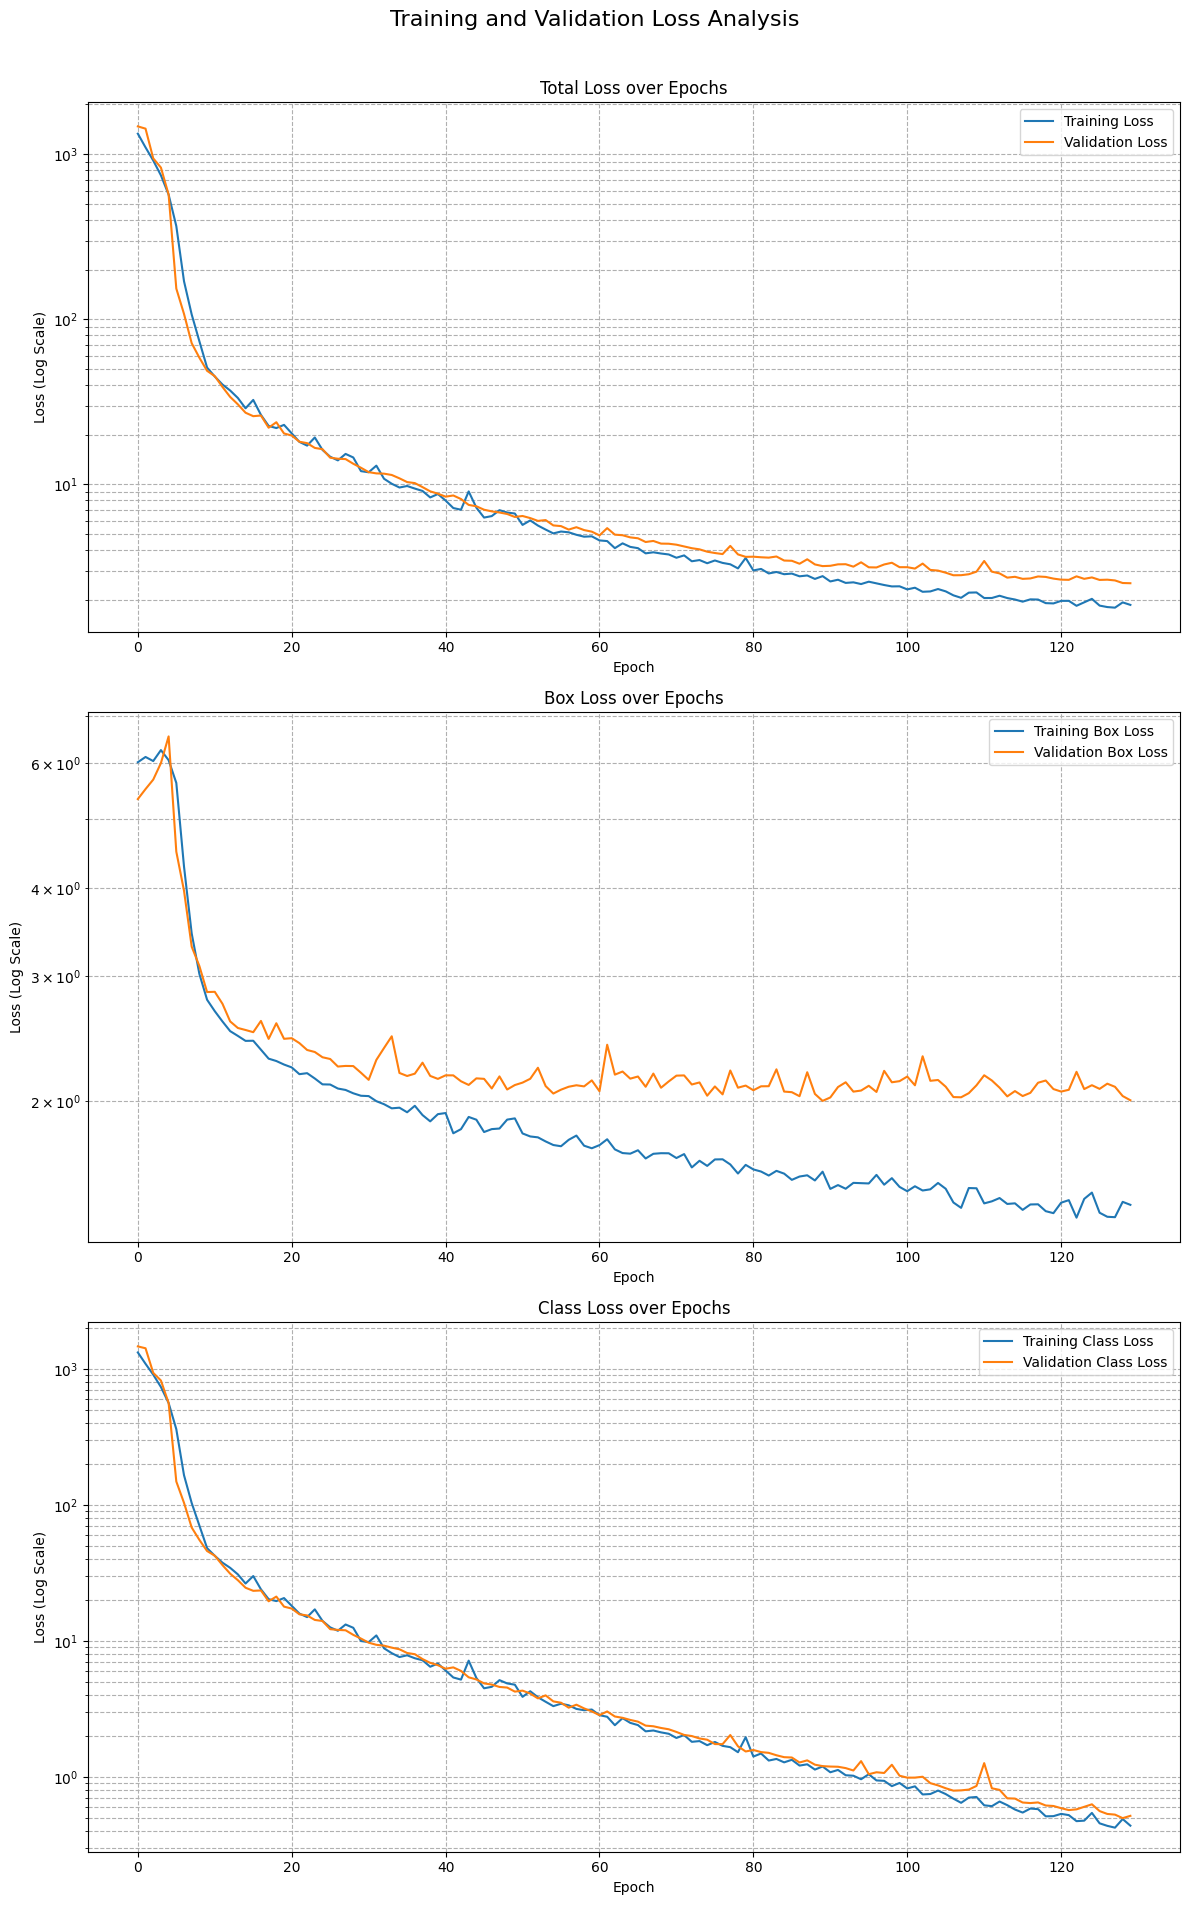


--- mAP ÏµúÏ¢Ö Í≤∞Í≥º ---
metrics/AP: 0.1274
metrics/AP50: 0.2553
metrics/AP75: 0.1085


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


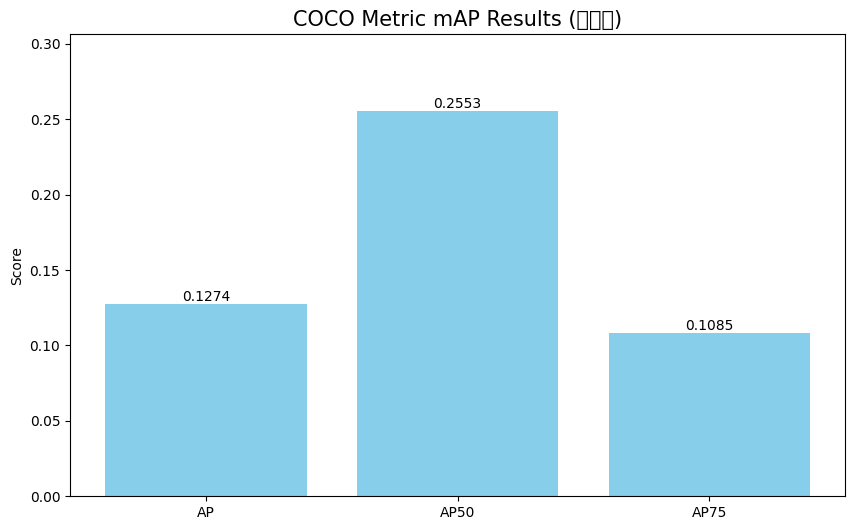


‚úÖ Î™®Îì† ÏãúÍ∞ÅÌôî ÏôÑÎ£å.

‚úÖ Î™®Îì† ÏãúÍ∞ÅÌôî ÏôÑÎ£å.


In [79]:
print("\n--- 7Îã®Í≥Ñ: ÌïôÏäµ Í≤∞Í≥º ÏãúÍ∞ÅÌôî ÏãúÏûë ---")

# --- 1. Î∞òÎ≥µÏ†ÅÏù∏ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞ ÏΩîÎìúÎ•º Ìï®ÏàòÎ°ú Ï†ïÏùò ---
def plot_loss_curve(ax, history, metric_name, title):
    """ÏßÄÏ†ïÎêú Ï∂ï(ax)Ïóê ÌïôÏäµ/Í≤ÄÏ¶ù ÏÜêÏã§ Í∑∏ÎûòÌîÑÎ•º Í∑∏Î¶¨Îäî Ìï®Ïàò"""
    
    train_metric = history.history[metric_name]
    val_metric = history.history[f'val_{metric_name}']
    
    ax.plot(train_metric, label=f'Training {metric_name.replace("_", " ").title()}')
    ax.plot(val_metric, label=f'Validation {metric_name.replace("_", " ").title()}')
    
    # yÏ∂ïÏùÑ Î°úÍ∑∏ Ïä§ÏºÄÏùºÎ°ú ÏÑ§Ï†ïÌïòÏó¨ ÎØ∏ÏÑ∏Ìïú Î≥ÄÌôîÎ•º Ïûò Î≥¥Ïù¥Í≤å Ìï®
    ax.set_yscale('log')
    
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (Log Scale)')
    ax.legend()
    ax.grid(True, which="both", ls="--")

# --- 2. 3Í∞úÏùò Í∑∏ÎûòÌîÑÎ•º ÌïòÎÇòÏùò Figure ÏïàÏóê ÏÑúÎ∏åÌîåÎ°ØÏúºÎ°ú Í∑∏Î¶¨Í∏∞ ---
# 3Ìñâ 1Ïó¥Ïùò ÏÑúÎ∏åÌîåÎ°ØÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
fig, axes = plt.subplots(3, 1, figsize=(12, 20))
fig.suptitle('Training and Validation Loss Analysis', fontsize=16)

# Ï≤´ Î≤àÏß∏ ÏÑúÎ∏åÌîåÎ°Ø: Ï†ÑÏ≤¥ ÏÜêÏã§ (Total Loss)
plot_loss_curve(axes[0], history, 'loss', 'Total Loss over Epochs')

# Îëê Î≤àÏß∏ ÏÑúÎ∏åÌîåÎ°Ø: Î∞ïÏä§ ÏÜêÏã§ (Box Loss)
plot_loss_curve(axes[1], history, 'box_loss', 'Box Loss over Epochs')

# ÏÑ∏ Î≤àÏß∏ ÏÑúÎ∏åÌîåÎ°Ø: ÌÅ¥ÎûòÏä§ ÏÜêÏã§ (Class Loss)
plot_loss_curve(axes[2], history, 'class_loss', 'Class Loss over Epochs')

# ÏÑúÎ∏åÌîåÎ°Ø Í∞Ñ Í∞ÑÍ≤© ÏûêÎèô Ï°∞Ï†à
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# --- 3. mAP ÏµúÏ¢Ö Í≤∞Í≥ºÎ•º ÌÖçÏä§Ìä∏ÏôÄ Î∞î Ï∞®Ìä∏Î°ú Î™®Îëê ÌëúÏãú ---
print("\n--- mAP ÏµúÏ¢Ö Í≤∞Í≥º ---")

# [ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ] ÏöîÏ≤≠ÌïòÏã† ÌòïÏãùÏóê ÎßûÍ≤å print() Íµ¨Î¨∏ÏùÑ Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
for metric_name, value in mAP_results.items():
    # "metrics/" Ï†ëÎëêÏÇ¨Î•º Î∂ôÏó¨ÏÑú Ï∂úÎ†•
    print(f"metrics/{metric_name}: {value:.4f}")

# Î∞î Ï∞®Ìä∏ ÏÉùÏÑ± ÏΩîÎìúÎäî Ïù¥Ï†ÑÍ≥º ÎèôÏùºÌï©ÎãàÎã§.
plt.figure(figsize=(10, 6))
bars = plt.bar(list(mAP_results.keys()), list(mAP_results.values()), color='skyblue')
plt.title('COCO Metric mAP Results (Í∑∏ÎûòÌîÑ)', fontsize=15)
plt.ylabel('Score')
plt.ylim(0, max(list(mAP_results.values())) * 1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()

print("\n‚úÖ Î™®Îì† ÏãúÍ∞ÅÌôî ÏôÑÎ£å.")


print("\n‚úÖ Î™®Îì† ÏãúÍ∞ÅÌôî ÏôÑÎ£å.")

In [ ]:
# --- 0. Í∏∞Î≥∏ ÏÑ§Ï†ï (ÌïôÏäµ ÏΩîÎìúÏôÄ ÎèôÏùºÌïòÍ≤å Ïú†ÏßÄ) ---
IMG_SIZE = 256 # ÌïôÏäµ Ïãú ÏÇ¨Ïö©ÌñàÎçò Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞
# ÌïôÏäµ Ïãú ÏÇ¨Ïö©ÌñàÎçò class_mappingÍ≥º ÎèôÏùºÌï¥Ïïº Ìï©ÎãàÎã§.
class_mapping = {
    'open': 0, 'short': 1, 'mousebite': 2, 'spur': 3, 'copper': 4, 'pin-hole': 5
}
# Ïó≠Îß§Ìïë (ÌÅ¥ÎûòÏä§ IDÎ•º Ïù¥Î¶ÑÏúºÎ°ú Î≥ÄÌôòÌïòÍ∏∞ ÏúÑÌï®)
id_to_class = {v: k for k, v in class_mapping.items()}

# --- 1. Î™®Îç∏ Î°úÎìú ---
# ModelCheckpoint ÏΩúÎ∞±Ïù¥ Ï†ÄÏû•Ìïú 'best_model.keras' ÌååÏùºÏùÑ Î°úÎìúÌï©ÎãàÎã§.
print("\n--- 1. Î™®Îç∏ Î°úÎìú ÏãúÏûë ---")
try:
    model_path = "best_model.keras" # ÌïôÏäµ Ï§ë Ï†ÄÏû•Îêú Î™®Îç∏ ÌååÏùº Í≤ΩÎ°ú
    loaded_model = keras.models.load_model(model_path, compile=False) # Ïª¥ÌååÏùº ÏóÜÏù¥ Î°úÎìú
    print(f"‚úÖ Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: '{model_path}'")
except Exception as e:
    print(f"‚ùå Î™®Îç∏ Î°úÎìú Ïã§Ìå®: {e}")
    print("WARNING: 'best_model.keras' ÌååÏùºÏù¥ ÌòÑÏû¨ ÎîîÎ†âÌÜ†Î¶¨Ïóê ÏûàÎäîÏßÄ, ÎòêÎäî Í≤ΩÎ°úÍ∞Ä Ïò¨Î∞îÎ•∏ÏßÄ ÌôïÏù∏ÌïòÏÑ∏Ïöî.")
    exit() 

# Î™®Îç∏Ïùò bounding_box_formatÏùÄ ÌïôÏäµ ÏãúÏôÄ ÎèôÏùºÌïú "xyxy"Î°ú Í∞ÄÏ†ïÌï©ÎãàÎã§.
bounding_box_format = "xyxy" 

# --- 2. ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï Î∞è ÌååÏùº Ï∞æÍ∏∞ ---
print("\n--- 2. ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Ï∞æÍ∏∞ ÏãúÏûë ---")
TEST_IMAGE_DIR = "/workspace/DeepPCB_split/test"
test_image_files = [f for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('_test.jpg')]
if not test_image_files:
    print(f"‚ùå Ïò§Î•ò: '{TEST_IMAGE_DIR}'ÏóêÏÑú '_test.jpg'Î°ú ÎÅùÎÇòÎäî Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
    exit()
else:
    print(f"‚úÖ '{TEST_IMAGE_DIR}'ÏóêÏÑú {len(test_image_files)}Í∞úÏùò ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ï∞æÏïòÏäµÎãàÎã§.")

# Ïù¥ÎØ∏ÏßÄÎ•º Î°úÎìúÌïòÍ≥† Î™®Îç∏ ÏûÖÎ†• ÌÅ¨Í∏∞Ïóê ÎßûÏ∂∞ Ï†ÑÏ≤òÎ¶¨Ìï©ÎãàÎã§.
def preprocess_image_for_inference(image_path, img_size):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        
        if tf.rank(image) != 3 or tf.reduce_any(tf.less_equal(tf.shape(image), 0)):
             raise tf.errors.InvalidArgumentError(None, None, f"Image {image_path} has invalid shape {tf.shape(image)}.")

        original_height, original_width = tf.shape(image)[0], tf.shape(image)[1] 
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.cast(image, dtype=tf.float32) / 255.0 
        image = tf.expand_dims(image, axis=0) 
        
        return image, tf.cast(original_height, tf.int32), tf.cast(original_width, tf.int32) 
    except (tf.errors.NotFoundError, tf.errors.InvalidArgumentError) as e:
        print(f"‚ùå Ïò§Î•ò: Ïù¥ÎØ∏ÏßÄ '{image_path}' Î°úÎî© ÎòêÎäî ÎîîÏΩîÎî© Ïã§Ìå®. Ìï¥Îãπ Ïù¥ÎØ∏ÏßÄÎäî Í±¥ÎÑàÎúÅÎãàÎã§. Ïò§Î•ò: {e}")
        # Ïò§Î•ò Î∞úÏÉù Ïãú ÎçîÎØ∏ Í∞í Î∞òÌôò (0 ÎÜíÏù¥/ÎÑàÎπÑÎ°ú ÎÇòÏ§ëÏóê Í±¥ÎÑàÎõ∞ÎèÑÎ°ù Ïú†ÎèÑ)
        return tf.zeros([1, img_size, img_size, 3], dtype=tf.float32), tf.constant(0, dtype=tf.int32), tf.constant(0, dtype=tf.int32)

# --- 3. Í∞Å ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú ÏòàÏ∏° Î∞è ÏãúÍ∞ÅÌôî Î∞òÎ≥µ ---
print("\n--- 3. Í∞Å ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú ÏòàÏ∏° Î∞è ÏãúÍ∞ÅÌôî ÏãúÏûë ---")

output_prediction_dir = "predictions_output"
os.makedirs(output_prediction_dir, exist_ok=True) # Ìè¥Îçî ÏÉàÎ°ú ÏÉùÏÑ±
print(f"‚úÖ ÏòàÏ∏° Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄÎäî '{output_prediction_dir}' Ìè¥ÎçîÏóê Ï†ÄÏû•Îê©ÎãàÎã§.")

# --- ‚≠ê‚≠ê CSV Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ïì∞Í∏∞ ‚≠ê‚≠ê ---
total_defects_count = len(scaled_pred_boxes)
    class_counts = {class_id: 0 for class_id in class_mapping.values()} # Î™®Îì† ÌÅ¥ÎûòÏä§ IDÎ•º 0ÏúºÎ°ú Ï¥àÍ∏∞Ìôî
    
    for class_id in pred_classes: # ÏòàÏ∏°Îêú ÌÅ¥ÎûòÏä§ IDÎßå Î∞òÎ≥µ (ÌïÑÌÑ∞ÎßÅ ÌõÑ ÎÇ®ÏùÄ Í≤ÉÎì§)
        if class_id in class_counts: # class_mappingÏóê ÏûàÎäî ÌÅ¥ÎûòÏä§Îßå Ïπ¥Ïö¥Ìä∏
            class_counts[class_id] += 1
            
    # CSV Ìñâ ÏÉùÏÑ±: [Image_Name, Total_Defects, open_count, short_count, ...]
    csv_row = [filename, total_defects_count]
    for class_name_key in class_mapping.keys(): # Ìó§Îçî ÏàúÏÑúÏóê ÎßûÏ∂∞ ÌÅ¥ÎûòÏä§Î≥Ñ Í∞úÏàò Ï∂îÍ∞Ä
        class_id = class_mapping[class_name_key]
        csv_row.append(class_counts[class_id])
    
    csv_writer.writerow(csv_row) # CSV ÌååÏùºÏóê Ïì∞Í∏∞
    print(f"  ‚úÖ '{filename}' ÏòàÏ∏° Í≤∞Í≥º CSVÏóê Í∏∞Î°ù ÏôÑÎ£å.")
    # --- ‚≠ê‚≠ê CSV Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ïì∞Í∏∞ ÎÅù ‚≠ê‚≠ê ---
for filename in test_image_files:
    current_test_image_path = os.path.join(TEST_IMAGE_DIR, filename)
    print(f"\nProcessing image: {current_test_image_path}")

    # --- 3.1. Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨ ---
    input_image, original_height, original_width = preprocess_image_for_inference(current_test_image_path, IMG_SIZE)
    
    # tf.equalÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌÖêÏÑú ÎπÑÍµê
    if tf.equal(original_height, 0) or tf.equal(original_width, 0): 
        print(f"Skipping '{filename}' due to invalid image dimensions (height={original_height.numpy()} or width={original_width.numpy()} from preprocessing).")
        continue 

    print(f"DEBUG: '{filename}' - ÏõêÎ≥∏ ÎÜíÏù¥: {original_height.numpy()}, ÌÉÄÏûÖ: {original_height.dtype}")
    print(f"DEBUG: '{filename}' - ÏõêÎ≥∏ ÎÑàÎπÑ: {original_width.numpy()}, ÌÉÄÏûÖ: {original_width.dtype}")

    # --- 3.2. Î™®Îç∏ ÏòàÏ∏° ÏàòÌñâ ---
    raw_predictions = loaded_model.predict(input_image)

    # --- 3.3. ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ (Ïã†Î¢∞ÎèÑ ÏûÑÍ≥ÑÍ∞í Ï†ÅÏö© Î∞è NMS) ---
    predictions_for_single_image = {
        "boxes": raw_predictions["boxes"][0],
        "classes": raw_predictions["classes"][0],
        "confidence": raw_predictions["confidence"][0],
    }

    confidence_threshold = 0.05
    mask = predictions_for_single_image["confidence"] >= confidence_threshold
    
    pred_boxes = predictions_for_single_image["boxes"][mask] 
    pred_classes = predictions_for_single_image["classes"][mask] 
    pred_confidence = predictions_for_single_image["confidence"][mask] 

    if len(pred_boxes) > 0: 
        selected_indices = tf.image.non_max_suppression(
            pred_boxes, 
            pred_confidence, 
            max_output_size=50, 
            iou_threshold=0.3
        )
        pred_boxes = tf.gather(pred_boxes, selected_indices).numpy()
        pred_classes = tf.gather(pred_classes, selected_indices).numpy()
        pred_confidence = tf.gather(pred_confidence, selected_indices).numpy()
    else: 
        pred_boxes = np.array([], dtype=np.float32).reshape(0, 4)
        pred_classes = np.array([], dtype=np.float32)
        pred_confidence = np.array([], dtype=np.float32)

    original_w_float_val = original_width.numpy().astype(np.float32)
    original_h_float_val = original_height.numpy().astype(np.float32)

    scale_x = original_w_float_val / IMG_SIZE 
    scale_y = original_h_float_val / IMG_SIZE

    scaled_pred_boxes = pred_boxes.copy() 
    if len(pred_boxes) > 0:
        # ‚≠ê‚≠ê ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ: Ïä§ÏπºÎùº Í≥±ÏÖà Ïãú .numpy()Î°ú Ïä§ÏπºÎùº Í∞íÎßå Ï∂îÏ∂ú ‚≠ê‚≠ê
        scaled_pred_boxes[:, 0] = pred_boxes[:, 0] * scale_x
        scaled_pred_boxes[:, 1] = pred_boxes[:, 1] * scale_y
        scaled_pred_boxes[:, 2] = pred_boxes[:, 2] * scale_x
        scaled_pred_boxes[:, 3] = pred_boxes[:, 3] * scale_y

    print(f"  ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ ÏôÑÎ£å. ÏµúÏ¢Ö Î∞ïÏä§ Í∞úÏàò: {len(scaled_pred_boxes)}")

    # --- 3.4. Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è ÌååÏùºÎ°ú Ï†ÄÏû• ---
    original_image = tf.io.read_file(current_test_image_path)
    original_image = tf.image.decode_jpeg(original_image, channels=3) 

    plt.figure(figsize=(12, 12))
    plt.imshow(original_image.numpy()) 
    ax = plt.gca()

    if len(scaled_pred_boxes) > 0:
        for i in range(len(scaled_pred_boxes)):
            box = scaled_pred_boxes[i]
            class_id = int(pred_classes[i])
            confidence = pred_confidence[i]
            
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            
            if class_id in id_to_class:
                color_idx = class_id % plt.cm.get_cmap('tab10').N 
                color = plt.cm.get_cmap('tab10')(color_idx)
            else:
                color = 'gray' 

            rect = plt.Rectangle((x_min, y_min), width, height,
                                 fill=False, edgecolor=color, linewidth=2)
            ax.add_patch(rect)
            
            label_text = f"{id_to_class.get(class_id, 'Unknown')}: {confidence:.2f}"
            ax.text(x_min, y_min - 5, label_text,
                    bbox=dict(facecolor=color, alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'),
                    fontsize=8, color='white', verticalalignment='bottom')

    plt.axis('off') 
    plt.title(f"Predicted Objects for: {filename}")
    
    output_filename_base, _ = os.path.splitext(filename) 
    output_image_path = os.path.join(output_prediction_dir, f"{output_filename_base}_predicted.png")
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0.1)
    plt.close() 

print("\nüéâ Î™®Îì† ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ ÏòàÏ∏° Î∞è ÏãúÍ∞ÅÌôî ÏôÑÎ£å.")


--- 1. Î™®Îç∏ Î°úÎìú ÏãúÏûë ---
‚úÖ Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: 'best_model.keras'

--- 2. ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Ï∞æÍ∏∞ ÏãúÏûë ---
‚úÖ '/workspace/DeepPCB_split/test'ÏóêÏÑú 500Í∞úÏùò .jpg Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùÑ Ï∞æÏïòÏäµÎãàÎã§.

--- 3. Í∞Å ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú ÏòàÏ∏° Î∞è ÏãúÍ∞ÅÌôî ÏãúÏûë ---
‚úÖ Í∏∞Ï°¥ 'predictions_output' Ìè¥ÎçîÎ•º ÏÇ≠Ï†úÌï©ÎãàÎã§.
‚úÖ ÏòàÏ∏° Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄÎäî 'predictions_output' Ìè¥ÎçîÏóê Ï†ÄÏû•Îê©ÎãàÎã§.
‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÏöîÏïΩÏùÄ 'predictions_output/test_defect_summary.csv' ÌååÏùºÏóê Ï†ÄÏû•Îê©ÎãàÎã§.

Processing image: /workspace/DeepPCB_split/test/00041200_test.jpg
1/1 [==============================] - 1s 1s/step
  ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ ÏôÑÎ£å. ÏµúÏ¢Ö Î∞ïÏä§ Í∞úÏàò: 1
  ‚úÖ '00041200_test.jpg' ÏòàÏ∏° Í≤∞Í≥º CSVÏóê Í∏∞Î°ù ÏôÑÎ£å.

Processing image: /workspace/DeepPCB_split/test/00041201_test.jpg
1/1 [==============================] - 0s 34ms/step


/tmp/ipykernel_1098/90390179.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_idx = class_id % plt.cm.get_cmap('tab10').N
/tmp/ipykernel_1098/90390179.py:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(color_idx)


  ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ ÏôÑÎ£å. ÏµúÏ¢Ö Î∞ïÏä§ Í∞úÏàò: 2
  ‚úÖ '00041201_test.jpg' ÏòàÏ∏° Í≤∞Í≥º CSVÏóê Í∏∞Î°ù ÏôÑÎ£å.

Processing image: /workspace/DeepPCB_split/test/00041202_test.jpg
1/1 [==============================] - 0s 34ms/step
  ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ ÏôÑÎ£å. ÏµúÏ¢Ö Î∞ïÏä§ Í∞úÏàò: 2
  ‚úÖ '00041202_test.jpg' ÏòàÏ∏° Í≤∞Í≥º CSVÏóê Í∏∞Î°ù ÏôÑÎ£å.

Processing image: /workspace/DeepPCB_split/test/00041203_test.jpg
1/1 [==============================] - 0s 32ms/step
  ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ ÏôÑÎ£å. ÏµúÏ¢Ö Î∞ïÏä§ Í∞úÏàò: 2
  ‚úÖ '00041203_test.jpg' ÏòàÏ∏° Í≤∞Í≥º CSVÏóê Í∏∞Î°ù ÏôÑÎ£å.

Processing image: /workspace/DeepPCB_split/test/00041204_test.jpg
1/1 [==============================] - 0s 33ms/step
  ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ ÏôÑÎ£å. ÏµúÏ¢Ö Î∞ïÏä§ Í∞úÏàò: 2
  ‚úÖ '00041204_test.jpg' ÏòàÏ∏° Í≤∞Í≥º CSVÏóê Í∏∞Î°ù ÏôÑÎ£å.

Processing image: /workspace/DeepPCB_split/test/00041205_test.jpg
1/1 [==============================] - 0s 32ms/step
  ‚úÖ ÏòàÏ∏° Í≤∞Í≥º ÌõÑÏ≤òÎ¶